# Import libraries

In [1]:
import sys
sys.path.append('../')
%matplotlib inline

In [2]:
from utils.utils import calc_AUC, calc_F1_score
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import utils.hsdmdl2_nml as hsdmdl2_nml
import utils.hsdmdl1_nml as hsdmdl1_nml
import utils.sdmdl_nml as sdmdl_nml
import tsmdl.aw2s_mdl as aw2s_mdl
import tsmdl.fw2s_mdl as fw2s_mdl
import dmdl.hsdmdl2 as hsdmdl2
import dmdl.hsdmdl1 as hsdmdl1
import dmdl.sdmdl as sdmdl
from functools import partial
import pandas as pd
import optuna
import changefinder
import bocpd
import datetime as dt

/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Preprocessing

In [3]:
def preprocessing(country, population):
    # 日付、死者、回復者、感染者のリスト
    deaths = pd.read_csv('./../data/time_series_covid19_deaths_global.csv')
    cases = pd.read_csv('./../data/time_series_covid19_confirmed_global.csv')
    recovered = pd.read_csv(
        './../data/time_series_covid19_recovered_global.csv')
    if country != "China" and country != "Canada":
        # 累計死亡数
        deaths = deaths[(deaths["Country/Region"] == country) &
                        (deaths["Province/State"].isnull() == True)].T.iloc[4:]
        deaths = deaths.reset_index()
        deaths.columns = ["date", "deaths"]
        deaths['date'] = pd.to_datetime(deaths['date'])

        # 累計感染数
        cases = cases[(cases["Country/Region"] == country) &
                      (cases["Province/State"].isnull() == True)].T.iloc[4:]
        cases = cases.reset_index()
        cases.columns = ["date", "cases"]
        cases['date'] = pd.to_datetime(cases['date'])

        # 累計完治数
        recovered = recovered[(recovered["Country/Region"] == country)
                              & (recovered["Province/State"].isnull() == True)].T.iloc[4:]
        recovered = recovered.reset_index()
        recovered.columns = ["date", "recovered"]
        recovered['date'] = pd.to_datetime(recovered['date'])
    else:
        deaths = deaths[(deaths["Country/Region"] == country)].iloc[:, 4:]
        cases = cases[(cases["Country/Region"] == country)].iloc[:, 4:]
        recovered = recovered[(recovered["Country/Region"]
                               == country)].iloc[:, 4:]
        deaths = deaths.sum().T
        cases = cases.sum().T
        recovered = recovered.sum().T

        deaths = deaths.reset_index()
        deaths.columns = ["date", "deaths"]
        deaths['date'] = pd.to_datetime(deaths['date'])
        cases = cases.reset_index()
        cases.columns = ["date", "cases"]
        cases['date'] = pd.to_datetime(cases['date'])
        recovered = recovered.reset_index()
        recovered.columns = ["date", "recovered"]
        recovered['date'] = pd.to_datetime(recovered['date'])

    start = cases[cases["cases"] > 0].reset_index(drop=True)["date"][0]
    end = pd.to_datetime("2020-9-1")
    cases = cases[(cases["date"] >= start) & (cases["date"] <= end)]
    deaths = deaths[(deaths["date"] >= start) & (deaths["date"] <= end)]
    recovered = recovered[(recovered["date"] >= start)
                          & (recovered["date"] <= end)]

    removed = deaths["deaths"]+recovered["recovered"]
    infectious = cases["cases"]-removed
    susceptibles = population-removed-infectious

    removed = removed/population
    infectious = infectious/population
    susceptibles = susceptibles/population

    data = pd.DataFrame({"date": cases["date"], "susceptibles": susceptibles,
                         "infectious": infectious, "removed": removed})

    return data

In [4]:
countries = ["Austria", "Belarus", "Belgium", "Brazil", "Canada", "Chile", "China", "Ecuador",
             "France", "Germany", "India", "Indonesia", "Iran", "Ireland", "Israel", "Italy", "Japan", "Mexico",
             "Netherlands", "Pakistan", "Peru", "Poland", "Portugal", "Qatar", "Romania", "Russia",
             "Saudi Arabia", "Singapore", "Korea, South", "Spain", "Sweden", "Switzerland", "Turkey",
             "United Arab Emirates", "Ukraine", "United Kingdom", "US"]

events_Austria = [pd.to_datetime('2020/3/16')]
events_Belarus = [pd.to_datetime('2020/4/9')]
events_Belgium = [pd.to_datetime('2020/3/18')]
events_Brazil = [pd.to_datetime('2020/3/24')]
events_Canada = [pd.to_datetime('2020/3/17')]
events_Chile = [pd.to_datetime('2020/3/26')]
events_China = [pd.to_datetime('2020/1/23')]
events_Ecuador = [pd.to_datetime('2020/3/16')]
events_France = [pd.to_datetime('2020/3/16')]
events_Germany = [pd.to_datetime('2020/3/16')]
events_India = [pd.to_datetime('2020/3/25')]
events_Indonesia = [pd.to_datetime('2020/4/10')]
events_Iran = [pd.to_datetime('2020/3/21')]
events_Ireland = [pd.to_datetime('2020/3/12')]
events_Israel = [pd.to_datetime('2020/4/2')]
events_Italy = [pd.to_datetime('2020/3/9')]
events_Japan = [pd.to_datetime('2020/4/7'), pd.to_datetime('2020/5/25')]
events_Mexico = [pd.to_datetime('2020/3/23')]
events_Netherlands = [pd.to_datetime('2020/3/15')]
events_Pakistan = [pd.to_datetime('2020/3/24')]
events_Peru = [pd.to_datetime('2020/3/18')]
events_Poland = [pd.to_datetime('2020/3/24')]
events_Portugal = [pd.to_datetime('2020/3/19')]
events_Qatar = [pd.to_datetime('2020/3/23')]
events_Romania = [pd.to_datetime('2020/3/23')]
events_Russia = [pd.to_datetime('2020/3/30')]
events_Saudi_Arabia = [pd.to_datetime('2020/3/29')]
events_Singapore = [pd.to_datetime('2020/4/7')]
events_South_Korea = [pd.to_datetime('2020/2/20')]
events_Spain = [pd.to_datetime('2020/3/14')]
events_Sweden = [pd.to_datetime('2020/3/24')]
events_Switzerland = [pd.to_datetime('2020/3/17')]
events_Turkey = [pd.to_datetime('2020/3/24')]
events_Ukraine = [pd.to_datetime('2020/3/17')]
events_United_Arab_Emirates = [pd.to_datetime('2020/3/31')]
events_United_Kingdom = [pd.to_datetime('2020/3/23')]
events_United_States = [pd.to_datetime('2020/3/19')]

events_all = {
    "Austria": events_Austria, "Belarus": events_Belarus, "Belgium": events_Belgium, "Brazil": events_Brazil,
    "Canada": events_Canada, "Chile": events_Chile, "China": events_China, "Ecuador": events_Ecuador,
    "France": events_France, "Germany": events_Germany, "India": events_India, "Indonesia": events_Indonesia, "Iran": events_Iran,
    "Ireland": events_Ireland, "Israel": events_Israel, "Italy": events_Italy, "Japan": events_Japan,
    "Mexico": events_Mexico, "Netherlands": events_Netherlands, "Pakistan": events_Pakistan, "Peru": events_Peru,
    "Poland": events_Poland, "Portugal": events_Portugal, "Qatar": events_Qatar, "Romania": events_Romania,
    "Russia": events_Austria, "Saudi Arabia": events_Saudi_Arabia, "Singapore": events_Singapore, "Korea, South": events_South_Korea,
    "Spain": events_Spain, "Sweden": events_Sweden, "Switzerland": events_Switzerland, "Turkey": events_Turkey, "Ukraine": events_Ukraine,
    "United Arab Emirates": events_United_Arab_Emirates, "United Kingdom": events_United_Kingdom, "US": events_United_States
}

In [5]:
def alarm_making(scores, threshold):
    alarms = np.where(scores >= threshold, 1, 0)
    alarms[0] = 0
    alarms[-1] = 0
    diff = np.diff(alarms)

    start = np.where(diff == 1)[0]

    return start

(224, 2)
[            nan             nan             nan             nan
             nan             nan -1.22543704e+01 -1.30027586e+01
 -1.37127759e+01 -1.39817350e+01 -1.39812996e+01 -1.36158001e+01
 -1.14271238e+01 -1.07162738e+01 -1.01825276e+01 -9.95788613e+00
 -1.00963979e+01 -1.01980544e+01 -1.02643936e+01 -1.03919700e+01
 -1.07205926e+01 -1.12353034e+01 -1.17815734e+01 -1.21961766e+01
 -1.24426173e+01 -1.28511795e+01 -1.32625879e+01 -1.32439934e+01
 -1.31475911e+01 -1.31879124e+01 -1.34332164e+01 -1.34356818e+01
 -1.33427382e+01 -1.34408225e+01 -1.33182262e+01 -1.29515674e+01
 -1.26608559e+01 -1.27265271e+01 -1.27656270e+01 -1.28263451e+01
 -1.29446432e+01 -1.32446757e+01 -1.38598647e+01 -1.44509753e+01
 -1.47234808e+01 -1.48226132e+01 -1.48912378e+01 -1.47074973e+01
 -1.44835062e+01 -1.40029025e+01 -1.39249259e+01 -1.38542603e+01
 -1.33573207e+01 -1.27506162e+01 -1.27412891e+01 -1.27817362e+01
 -1.29469944e+01 -1.64047725e+01 -1.71989249e+01 -1.75792200e+01
 -1.76325108e+01

             nan             nan             nan             nan]


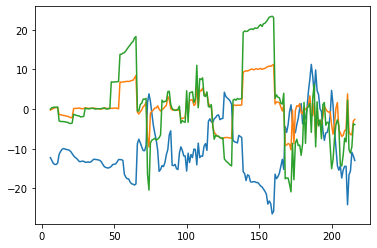

In [6]:
def calc_statistics(country, events_all):
    # 人口
    population_csv = pd.read_csv('./../data/population.csv')
    for index, row in population_csv.iterrows():
        if row["Country Name"] == country:
            population = float(row["2015"])
    df = preprocessing(country, population)
    events = events_all[country]

    # データ
    susceptibles = np.array(df["susceptibles"]).astype(float)
    infectious = np.array(df["infectious"]).astype(float)
    removed = np.array(df["removed"]).astype(float)
    data_enc = np.r_['1', infectious.reshape(
        (-1, 1)), removed.reshape((-1, 1))]
    print(data_enc.shape)
    cum_cases = infectious+removed

    # hyperparameters
    mu_max = 10
    div_min = 1e-2
    div_max = 1e2
    gamma = 0.1
    beta_init = 0.5
    eps = 1/population
    shift = False

    # SD-MDL
    sir_gaussian = partial(sdmdl_nml.sir_gaussian, mu_max=mu_max,
                           div_min=div_min, div_max=div_max, gamma=gamma,
                           beta_init=beta_init, eps=eps)
    sir_comp_gaussian = partial(
        sdmdl_nml.complexity_gaussian, mu_max=mu_max, div_min=div_min, div_max=div_max)

    delta_0 = 0.05
    window_size = 7
    retrospective = sdmdl.Retrospective(
        h=window_size, encoding_func=sir_gaussian, complexity_func=sir_comp_gaussian, delta_0=delta_0, shift=shift)

    sdmdl_scores, _ = retrospective.calc_all_stats(data_enc)

    print(sdmdl_scores[0])
    print(sdmdl_scores[1])
    print(sdmdl_scores[2])

    plt.clf()
    plt.plot(sdmdl_scores[0])
    plt.plot(sdmdl_scores[1])
    plt.plot(sdmdl_scores[2])
    plt.show()

    # FW2S-MDL
    sir_gaussian = partial(sdmdl_nml.sir_gaussian, mu_max=mu_max,
                           div_min=div_min, div_max=div_max, gamma=gamma,
                           beta_init=beta_init, eps=eps)
    complexity_gaussian = partial(
        sdmdl_nml.complexity_gaussian, mu_max=mu_max, div_min=div_min, div_max=div_max)

    delta_0 = 0.05
    window_size_1 = 7
    window_size_2 = 7
    mu_max_stage2 = 10
    div_min_stage2 = 1e-2
    div_max_stage2 = 1e2

    nml_gaussian = partial(sdmdl_nml.nml_gaussian, mu_max=mu_max_stage2,
                           div_min=div_min_stage2, div_max=div_max_stage2)
    complexity_gaussian = partial(sdmdl_nml.complexity_gaussian,
                                  mu_max=mu_max_stage2, div_min=div_min_stage2, div_max=div_max_stage2)

    retrospective_first = sdmdl.Retrospective(
        h=window_size_1, encoding_func=sir_gaussian, complexity_func=complexity_gaussian, delta_0=delta_0, order=0)
    retrospective_second = sdmdl.Retrospective(h=window_size_2, encoding_func=nml_gaussian,
                                               complexity_func=complexity_gaussian, order=0)

    retrospective = fw2s_mdl.Retrospective(
        retrospective_first, retrospective_second, shift=shift)
    fw2s_mdl_scores = retrospective.calc_scores(data_enc)

    # CF
    retrospective = changefinder.Retrospective(
        r=0.1, order=10, smooth=10)
    cf_scores = retrospective.calc_scores(-np.log(cum_cases))

    # BOCPD
    lam = 50
    alpha = 6
    beta = 0.1
    kappa = 0.1
    mu = 0

    h = partial(bocpd.constant_hazard, lam)
    lik = bocpd.StudentT(alpha, beta, kappa, mu)
    retrospective = bocpd.Retrospective(hazard_func=h, likelihood_func=lik)
    bocpd_scores = retrospective.calc_scores(-np.log(cum_cases))

    return cum_cases, df, sdmdl_scores, fw2s_mdl_scores, cf_scores, bocpd_scores


cum_cases, df, sdmdl_scores, fw2s_mdl_scores, cf_scores, bocpd_scores = calc_statistics(
    country="Japan", events_all=events_all)

[ 77 125]
2020-01-22 00:00:00
2020-09-01 00:00:00
SDMDL 0th:  0.8001982419473812
SDMDL 1st:  0.3883160191787558
SDMDL 2nd:  0.38329850012294076
FW2S-MDL:  0.7188883083353826
ChangeFinder:  0.5838302188345217
BOCPD:  0.41541676911728537


/Users/ryo/.pyenv/versions/anaconda3-5.3.1/envs/wantedly/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


SDMDL 0th:  (0.8, -8.240045496436519)
SDMDL 1st:  (1.0, 7.872397521228136)
SDMDL 2nd:  (1.0, 17.647811790519047)
FW2S-MDL:  (1.0, 5.871649692281018)
ChangeFinder:  (0.3333333333333333, -1.5520984390831714)
BOCPD:  (0.5, 0.05932897957627553)


<Figure size 432x288 with 0 Axes>

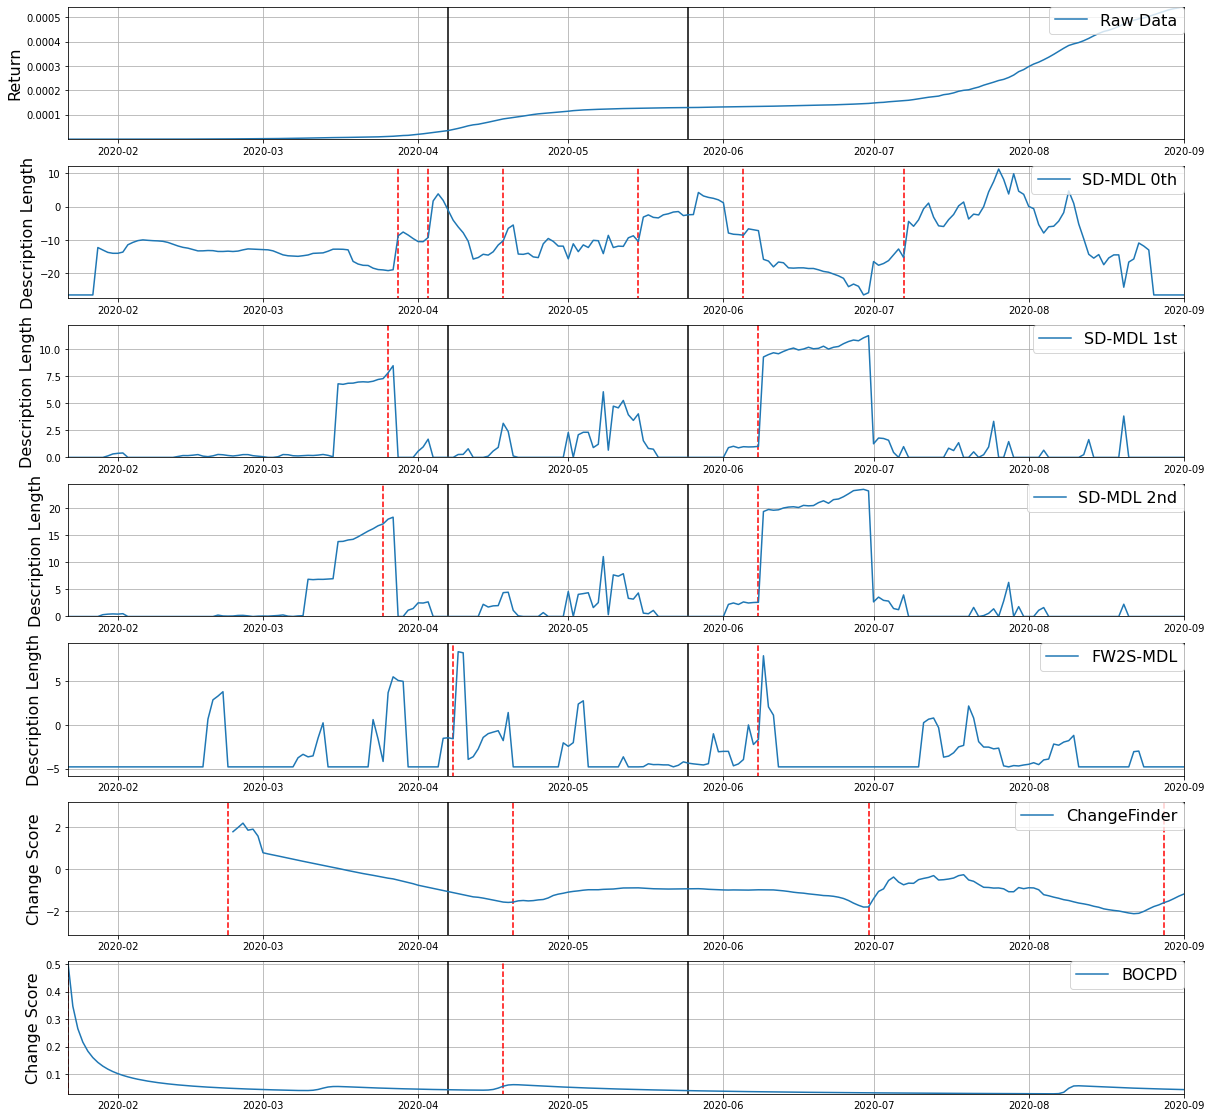

In [11]:
def country_graph(country, events_all, cum_cases, df, sdmdl_0_scores, sdmdl_1_scores, sdmdl_2_scores, fw2s_mdl_scores, cf_scores, bocpd_scores, tolerance_delay, both):

    events = events_all[country]
    changepoints = []

    for i in range(len(events)):
        cp_idx = len(df[df['date'] <= events[i]])
        changepoints.append(cp_idx)

    changepoints = np.array(changepoints)
    print(changepoints)

    start_date = df['date'][0]
    end_date = df['date'][len(df)-1]
    print(start_date)
    print(end_date)

    # fill na
    sdmdl_0_scores[np.isnan(sdmdl_0_scores)] = np.nanmin(sdmdl_0_scores)
    sdmdl_1_scores[np.isnan(sdmdl_1_scores)] = np.nanmin(sdmdl_1_scores)
    sdmdl_2_scores[np.isnan(sdmdl_2_scores)] = np.nanmin(sdmdl_2_scores)
    fw2s_mdl_scores[np.isnan(fw2s_mdl_scores)] = np.nanmin(fw2s_mdl_scores)

    sdmdl_1_scores = np.where(sdmdl_1_scores < 0, 0, sdmdl_1_scores)
    sdmdl_2_scores = np.where(sdmdl_2_scores < 0, 0, sdmdl_2_scores)

    # AUC
    print("SDMDL 0th: ", calc_AUC(sdmdl_0_scores,
                                  changepoints,  tolerance_delay, both=both))
    print("SDMDL 1st: ", calc_AUC(sdmdl_1_scores,
                                  changepoints,  tolerance_delay, both=both))
    print("SDMDL 2nd: ", calc_AUC(sdmdl_2_scores,
                                  changepoints,  tolerance_delay, both=both))
    print("FW2S-MDL: ", calc_AUC(fw2s_mdl_scores,
                                 changepoints,  tolerance_delay, both=both))
    print("ChangeFinder: ", calc_AUC(
        cf_scores, changepoints,  tolerance_delay, both=both))
    print("BOCPD: ", calc_AUC(bocpd_scores,
                              changepoints,  tolerance_delay, both=both))

    # F1 and threshold tuning
    sdmdl_0_F1, _, _, sdmdl_0_threshold = calc_F1_score(
        sdmdl_0_scores, changepoints, tolerance_delay)
    sdmdl_1_F1, _, _, sdmdl_1_threshold = calc_F1_score(
        sdmdl_1_scores, changepoints, tolerance_delay)
    sdmdl_2_F1, _, _, sdmdl_2_threshold = calc_F1_score(
        sdmdl_2_scores, changepoints, tolerance_delay)
    fw2s_mdl_F1, _, _, fw2s_mdl_threshold = calc_F1_score(
        fw2s_mdl_scores, changepoints, tolerance_delay)
    cf_F1, _, _, cf_threshold = calc_F1_score(
        cf_scores, changepoints, tolerance_delay)
    bocpd_F1, _, _, bocpd_threshold = calc_F1_score(
        bocpd_scores, changepoints, tolerance_delay)

    sdmdl_0_alarm = alarm_making(sdmdl_0_scores, sdmdl_0_threshold)
    sdmdl_1_alarm = alarm_making(sdmdl_1_scores, sdmdl_1_threshold)
    sdmdl_2_alarm = alarm_making(sdmdl_2_scores, sdmdl_2_threshold)
    fw2s_mdl_alarm = alarm_making(fw2s_mdl_scores, fw2s_mdl_threshold)
    cf_alarm = alarm_making(cf_scores, cf_threshold)
    bocpd_alarm = alarm_making(bocpd_scores, bocpd_threshold)

    print("SDMDL 0th: ", (sdmdl_0_F1, sdmdl_0_threshold))
    print("SDMDL 1st: ", (sdmdl_1_F1, sdmdl_1_threshold))
    print("SDMDL 2nd: ", (sdmdl_2_F1, sdmdl_2_threshold))
    print("FW2S-MDL: ", (fw2s_mdl_F1, fw2s_mdl_threshold))
    print("ChangeFinder: ", (cf_F1, cf_threshold))
    print("BOCPD: ", (bocpd_F1, bocpd_threshold))

    plt.clf()
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20, 20))

    fontsize = 16

    axes[0].plot(df['date'], cum_cases, label='Raw Data')
    axes[0].set_ylabel('Return', fontsize=fontsize)
    axes[0].vlines(events, -100, 100, color="black")
    axes[0].set_ylim(np.min(cum_cases), np.max(cum_cases))
    axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[0].set_xlim(start_date, end_date)
    axes[0].grid(True)

    axes[1].plot(df['date'], sdmdl_0_scores, label='SD-MDL 0th')
    axes[1].set_ylabel('Description Length', fontsize=fontsize)
    axes[1].vlines(events, -100, 100, color="black")
    axes[1].vlines(df['date'][sdmdl_0_alarm], -100,
                   100, color="red", linestyle="dashed")
    axes[1].set_ylim(np.nanmin(sdmdl_0_scores)-1, np.nanmax(sdmdl_0_scores)+1)
    axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[1].set_xlim(start_date, end_date)
    axes[1].grid(True)

    axes[2].plot(df['date'], sdmdl_1_scores, label='SD-MDL 1st')
    axes[2].set_ylabel('Description Length', fontsize=fontsize)
    axes[2].vlines(events, -100, 100, color="black")
    axes[2].vlines(df['date'][sdmdl_1_alarm], -100,
                   100, color="red", linestyle="dashed")
    axes[2].set_ylim(0, np.nanmax(sdmdl_1_scores)+1)
    axes[2].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[2].set_xlim(start_date, end_date)
    axes[2].grid(True)

    axes[3].plot(df['date'], sdmdl_2_scores, label='SD-MDL 2nd')
    axes[3].set_ylabel('Description Length', fontsize=fontsize)
    axes[3].vlines(events, -100, 100, color="black")
    axes[3].vlines(df['date'][sdmdl_2_alarm], -100,
                   100, color="red", linestyle="dashed")
    axes[3].set_ylim(0, np.nanmax(sdmdl_2_scores)+1)
    axes[3].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[3].set_xlim(start_date, end_date)
    axes[3].grid(True)

    axes[4].plot(df['date'], fw2s_mdl_scores, label='FW2S-MDL')
    axes[4].set_ylabel('Description Length', fontsize=fontsize)
    axes[4].vlines(events, -100, 100, color="black")
    axes[4].vlines(df['date'][fw2s_mdl_alarm], -100,
                   100, color="red", linestyle="dashed")
    axes[4].set_ylim(np.nanmin(fw2s_mdl_scores)-1,
                     np.nanmax(fw2s_mdl_scores)+1)
    axes[4].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[4].set_xlim(start_date, end_date)
    axes[4].grid(True)

    axes[5].plot(df['date'], cf_scores, label='ChangeFinder')
    axes[5].set_ylabel('Change Score', fontsize=fontsize)
    axes[5].vlines(events, -100, 100, color="black")
    axes[5].vlines(df['date'][cf_alarm], -100, 100,
                   color="red", linestyle="dashed")
    axes[5].set_ylim(np.nanmin(cf_scores)-1, np.nanmax(cf_scores)+1)
    axes[5].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[5].set_xlim(start_date, end_date)
    axes[5].grid(True)

    axes[6].plot(df['date'], bocpd_scores, label='BOCPD')
    axes[6].set_ylabel('Change Score', fontsize=fontsize)
    axes[6].vlines(events, -100, 100, color="black")
    axes[6].vlines(df['date'][bocpd_alarm], -100, 100,
                   color="red", linestyle="dashed")
    axes[6].set_ylim(np.nanmin(bocpd_scores), np.nanmax(bocpd_scores))
    axes[6].legend(bbox_to_anchor=(1, 1), loc='upper right',
                   borderaxespad=0, fontsize=fontsize)
    axes[6].set_xlim(start_date, end_date)
    axes[6].grid(True)


tolerance_delay = 14
both = True

country_graph('Japan', events_all, cum_cases, df, sdmdl_scores[0], sdmdl_scores[1], sdmdl_scores[2],
              fw2s_mdl_scores, cf_scores, bocpd_scores, tolerance_delay, both)